In [1]:
# 日線量價吞噬前根紅Ｋ 進場
# RSI > 68 & KD > 80 或 紅Ｋ貫穿布林Ｍ往下 (第二條件實測發現吃掉大量停利空間)
# ! conda install -c conda-forge ta --yes

In [2]:
import pandas as pd
import ta
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import time
import os

In [3]:
timezone = -3
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
rate = 30
interval = '1d'
limit = 1000

# start epoch till now
start_time = 1609492611000
end_time = round(time.time() * 1000)

# step between timestamps in milliseconds, 60000 = 1min
step = 60000 * 3600

In [4]:
from binance.client import Client
from dotenv import load_dotenv

# Get the path to the current directory
current_directory = os.getcwd()

# Specify the path to the .env file relative to the current directory
dotenv_path = os.path.join(current_directory, '.env')

# Load the environment variables from the .env file
load_dotenv(dotenv_path)

api_key = os.getenv('API_KEY')
api_secret = os.getenv('SECRET_KEY')

client = Client(api_key, api_secret, testnet = False)

spot = client.get_account()
s_bal = pd.DataFrame(spot['balances'])
print(s_bal)

      asset        free      locked
0       BTC  0.00000000  0.00000000
1       LTC  0.00000000  0.00000000
2       ETH  0.00000000  0.00000000
3       NEO  0.00000000  0.00000000
4       BNB  0.04622450  0.00000000
..      ...         ...         ...
539    PEPE        0.00        0.00
540   FLOKI        0.00        0.00
541   COMBO  0.00000000  0.00000000
542     MAV  0.00000000  0.00000000
543  PENDLE  0.00000000  0.00000000

[544 rows x 3 columns]


In [5]:
def get_historical(symbol, interval, start_time, end_time, step):
    
    data = []    
    while start_time < end_time:
        limit = min(step, end_time - start_time + 1)  # Adjust the limit for the last batch
        while True:
            try:
                response = client.get_klines(symbol=symbol.upper(), interval=interval, limit=limit, startTime=start_time)
                break
            except:
                time.sleep(5)
        if len(response) == 0:
            break  # No more data available, exit the loop
        data.extend(response)
        start_time = response[-1][0] + 1
    
    # Convert the data to a DataFrame
    columns = [
        "Open_Time", "Open", "High", "Low", "Close", "Volume", "Close_Time",
        "Quote asset volume", "Number of trades", "Taker buy base asset volume",
        "Taker buy quote asset volume", "Ignore"
    ]
    raw_df = pd.DataFrame(data, columns=columns)   
    
    raw_df = raw_df[['Open_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Open_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    raw_df = raw_df.astype(convert_dict)

    raw_df['Open_Time'] = pd.to_datetime(raw_df['Open_Time'], unit = 'ms')
    raw_df['Open_Time'] = raw_df['Open_Time'] + pd.Timedelta(hours=timezone)
    raw_df['Open_Time'] = raw_df['Open_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    raw_df = raw_df.reset_index(drop=True)
    
    return raw_df

In [6]:
rawdf = get_historical(symbol, interval, start_time, end_time, step)
print(rawdf)

               Open_Time     Open    Close     High      Low        Volume
0    2021-01-01 21:00:00   728.91   774.56   787.69   714.91  1.352619e+06
1    2021-01-02 21:00:00   774.44   978.28  1011.07   768.71  2.813604e+06
2    2021-01-03 21:00:00   978.33  1041.43  1162.97   890.00  4.245011e+06
3    2021-01-04 21:00:00  1041.45  1099.56  1134.60   974.45  2.706996e+06
4    2021-01-05 21:00:00  1100.16  1208.42  1213.00  1057.26  2.390137e+06
..                   ...      ...      ...      ...      ...           ...
911  2023-07-01 21:00:00  1924.50  1937.48  1959.20  1885.75  2.558528e+05
912  2023-07-02 21:00:00  1937.49  1955.54  1976.16  1933.55  3.221024e+05
913  2023-07-03 21:00:00  1955.55  1936.20  1967.08  1931.58  2.055251e+05
914  2023-07-04 21:00:00  1936.19  1910.36  1942.50  1894.51  2.676335e+05
915  2023-07-05 21:00:00  1910.35  1859.29  1958.00  1855.00  4.305945e+05

[916 rows x 6 columns]


In [7]:
df = rawdf.copy()

In [8]:
def indicators(df):
# bband
    bb_int = 30
    bb_dev = 2
    bb = ta.volatility.BollingerBands(df['Close'], window=bb_int, window_dev=bb_dev)
    df['bb_u'] = bb.bollinger_hband()
    df['bb_m'] = bb.bollinger_mavg()
    df['bb_l'] = bb.bollinger_lband()
# rsi
    rsi_int = 14
    df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()
# kd
    kd_int = 14
    d_int = 3
    
    # Calculate Stochastic Oscillator
    kddf = pd.DataFrame()
    kddf[str(kd_int) + '-Low'] = df['Low'].rolling(kd_int).min()
    kddf[str(kd_int) + '-High'] = df['High'].rolling(kd_int).max()
    df['slowk'] = (df['Close'] - kddf[str(kd_int) + '-Low'])*100/(kddf[str(kd_int) + '-High'] - kddf[str(kd_int) + '-Low'])
    df['slowd'] = df['slowk'].rolling(d_int).mean()
    return df

In [9]:
indicators(df)

,Open_Time,Open,Close,High,Low,Volume,bb_u,bb_m,bb_l,rsi,slowk,slowd
0,2021-01-01 21:00:00,728.91,774.56,787.69,714.91,1.352619e+06,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-02 21:00:00,774.44,978.28,1011.07,768.71,2.813604e+06,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-03 21:00:00,978.33,1041.43,1162.97,890.00,4.245011e+06,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-04 21:00:00,1041.45,1099.56,1134.60,974.45,2.706996e+06,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-05 21:00:00,1100.16,1208.42,1213.00,1057.26,2.390137e+06,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
911,2023-07-01 21:00:00,1924.50,1937.48,1959.20,1885.75,2.558528e+05,1981.839090,1821.593667,1661.348244,60.512855,91.684533,92.052599
912,2023-07-02 21:00:00,1937.49,1955.54,1976.16,1933.55,3.221024e+05,1989.211433,1823.709667,1658.207901,62.109178,92.112913,91.393509
913,2023-07-03 21:00:00,1955.55,1936.20,1967.08,1931.58,2.055251e+05,1994.016820,1825.249333,1656.481847,59.342527,78.832503,87.543316
914,2023-07-04 21:00:00,1936.19,1910.36,1942.50,1894.51,2.676335e+05,1999.969313,1828.578000,1657.186687,55.768109,58.771930,76.572449


In [10]:
def conditions(df):

    # c1 日線收在下布林
    # c2 本Ｋ為綠Ｋ 前一天為紅Ｋ
    # c3 量大於前日
    # c4 收盤大於前日開盤 (discarded)
    # rsi > 45
    
    for index, row in df.iterrows():
        # c1
        df['c1'] = df['Close'] < df['bb_m']
        # c2
        df['c2'] = (df['Close'] - df['Open'] > 0) & (df['Close'].shift(1) - df['Open'].shift(1) < 0) 
        # c3
        df['c3'] = df['Volume'] > df['Volume'].shift(1)
        # c4
        df['c4'] = df['Close'] > df['Open'].shift(1)
        # c5
        df['c5'] = df['rsi'] >= 30

    # 條件達成
    df['signal'] = False
    df.loc[df.c1 & df.c2 & df.c3 & df.c4 & df.c5 , 'signal'] = True


    # 下一根進場
    df['openbuy'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'openbuy'] = True

In [11]:
conditions(df)

In [12]:
buydf = df.copy()

# 進出場

in_position = False
stop_loss = np.nan

for index, row in buydf.iterrows():

    tp_rsi = 68
    tp_slowk = 80
    tp_slowd = 80
    
    if index == 0:
        continue
        
        # set entry price (前一根Ｋ收盤價進場)
        # set stop loss (前一根Ｋ線低點停損)
        # 進場
    elif buydf.at[index, 'openbuy'] == True:
        close_val = buydf['Close']
        low_val = buydf['Low']
        buydf.at[index, 'entry_p'] = close_val.shift(1).at[index]
        buydf.at[index, 'stop_loss'] = low_val.shift(1).at[index]
        buydf.at[index, 'position'] = 'Buy'
        in_position = True
        stop_loss = low_val.shift(1).at[index]
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position == True and buydf.at[index, 'Close'] < stop_loss:
        buydf.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan

    # set take profit （RSI > 68 & KD > 80）
    elif in_position == True and (((buydf.at[index, 'rsi'] >= tp_rsi) & 
                                  (buydf.at[index, 'slowk'] >= tp_slowk) & 
                                  (buydf.at[index, 'slowd'] >= tp_slowd) & 
                                  (buydf.at[index, 'Close'] <= buydf.at[index, 'bb_u'])) or
                                  ((buydf.at[index - 1, 'Close'] > buydf.at[index, 'bb_m']) & 
                                   (buydf.at[index, 'Close'] < buydf.at[index, 'bb_m']))):
        buydf.at[index, 'position'] = 'Sell'
        in_position = False
        stop_loss = np.nan
        
#     elif in_position == True and ((buydf.at[index, 'Close'] < buydf.at[index, 'bb_m']) & (buydf.at[index, 'Open'] > buydf.at[index, 'bb_m'])):
#         buydf.at[index, 'position'] = 'Sell'
#         in_position = False
#         stop_loss = np.nan

        
# 過濾有訊號或事件發生的Ｋ線
buydf = buydf[(buydf['openbuy'] == True) |
              (buydf['signal'] == True) | 
              (buydf['position'] == 'Buy') |
              (buydf['position'] == 'Sell') |
              (buydf['position'] == 'Stop')]


print(buydf)


               Open_Time     Open    Close     High      Low        Volume  \
63   2021-03-05 21:00:00  1528.08  1650.35  1671.58  1513.03  1.013301e+06   
64   2021-03-06 21:00:00  1650.68  1726.16  1734.16  1630.35  8.484708e+05   
79   2021-03-21 21:00:00  1783.23  1680.97  1807.51  1655.15  5.827275e+05   
169  2021-06-19 21:00:00  2165.34  2243.47  2280.01  2040.68  7.438836e+05   
170  2021-06-20 21:00:00  2243.49  1885.49  2260.16  1865.54  1.629820e+06   
..                   ...      ...      ...      ...      ...           ...   
843  2023-04-24 21:00:00  1841.84  1866.10  1877.86  1801.66  4.578706e+05   
844  2023-04-25 21:00:00  1866.10  1866.01  1964.72  1785.00  8.977097e+05   
854  2023-05-05 21:00:00  1993.30  1896.33  2019.00  1860.00  6.081070e+05   
898  2023-06-18 21:00:00  1720.95  1737.11  1752.19  1698.00  2.451628e+05   
899  2023-06-19 21:00:00  1737.10  1791.99  1796.99  1714.72  3.288557e+05   

            bb_u         bb_m         bb_l        rsi  ...     

In [13]:
# 整理
def organize(df):
    df['Volume'] = round(df['Volume'], 2)
    df['bb_u'] = round(df['bb_u'], 2)
    df['bb_m'] = round(df['bb_m'], 2)
    df['bb_l'] = round(df['bb_l'], 2)
    df['rsi'] = round(df['rsi'], 2)
    df['slowk'] = round(df['slowk'], 2)
    df['slowd'] = round(df['slowd'], 2)

    return df

In [14]:
# 部位回測

organize(buydf)

posdf = buydf.copy()
posdf = posdf.reset_index(drop = True)
posdf = posdf[(posdf['position'] == 'Buy') |
              (posdf['position'] == 'Sell') |
              (posdf['position'] == 'Stop')]

# 一次進場多少單位
pos_size = 1

col = ['Open_Time', 'Open', 'Close', 'High', 'Low', 'Volume', 'bb_u', 'bb_l', 'rsi', 'slowk', 'slowd', 'position','entry_p', 'stop_loss']
pos = posdf[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：RSI > 68 & KD > 80，出場價設定為該日收盤
        if pos.at[index, 'position'] == 'Sell':
            pos.at[index, 'exit_p'] = pos.at[index, 'Close'] * 1

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[index, 'Close']
                break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Buy':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)

        
# 若最後一筆為 Buy，移除該單，迭代驗證，避免結算獲利錯誤
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Buy':
        pos = pos.drop(index)
    else:
        break
    
        
print(pos)
pos.to_csv('pos.csv')


# 手續費、滑點、價差
fee = 0.05 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee

# 損益
leverage = 10
ttl_profit = -pos.amt.sum() - ttl_fee


# 計算進場最大部位來代表總進場成本，以計算報酬率
pos['consec_entry'] = (pos['position'] != pos['position'].shift()).cumsum()
group_consec = pos.groupby('consec_entry').apply(lambda x:x.loc[x['position'] == 'Buy', 'amt' ].sum())
max_entry = group_consec.max()

profit_per = "{:.2f}%".format(ttl_profit / (max_entry/leverage) * 100)

wins = pos['position'].str.count('Sell').sum()
loses = pos['position'].str.count('Stop').sum()
win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)

result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Entry': [round(max_entry, 2)],
          'Profit_%': [profit_per],
          'Win_Rate': [win_rate]}

result_df = pd.DataFrame(result)

print(result_df)



              Open_Time     Open    Close     High      Low      Volume  \
0   2021-03-06 21:00:00  1650.68  1726.16  1734.16  1630.35   848470.78   
1   2021-03-21 21:00:00  1783.23  1680.97  1807.51  1655.15   582727.49   
2   2021-06-20 21:00:00  2243.49  1885.49  2260.16  1865.54  1629819.67   
3   2021-06-21 21:00:00  1885.27  1879.28  1998.00  1700.48  1695338.08   
4   2021-07-21 21:00:00  1995.50  2024.56  2046.00  1947.62   768854.37   
5   2021-08-07 21:00:00  3160.48  3011.85  3189.99  2949.03   966349.71   
6   2021-09-26 21:00:00  3059.36  2925.59  3164.94  2922.71   510130.73   
7   2021-11-07 21:00:00  4612.59  4807.98  4822.97  4612.00   391102.32   
8   2021-12-23 21:00:00  4111.41  4046.36  4134.84  4017.17   230833.17   
9   2021-12-27 21:00:00  4037.22  3792.75  4037.23  3759.36   358064.72   
10  2022-03-14 21:00:00  2589.42  2617.73  2669.00  2507.00   461202.30   
11  2022-03-29 21:00:00  3400.51  3385.79  3446.90  3331.84   356082.52   
12  2022-04-25 21:00:00  

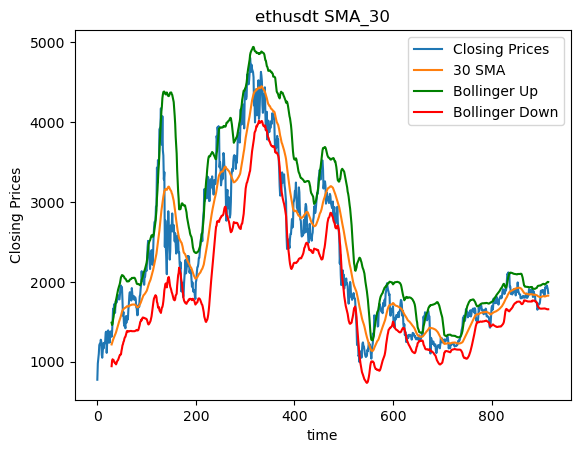

In [15]:
plt.title(symbol + ' SMA_' + str(rate))
plt.xlabel('time')
plt.ylabel('Closing Prices')
plt.plot(df.Close, label='Closing Prices')
plt.plot(df.bb_m, label= str(rate) + ' SMA')
plt.plot(df.bb_u, label='Bollinger Up', c='g')
plt.plot(df.bb_l, label='Bollinger Down', c='r')
plt.legend()
plt.show()